In [1]:
import pandas as pd
import csv
import time
from astroquery.sdss import SDSS
import astropy.units as u
from astropy.coordinates import SkyCoord

# 读取CSV文件
starid = pd.read_csv('DR11中所有的在权威星表里的中分辨率红巨星.csv')
ra=starid['ra']
dec = starid['dec']
ids=starid['obsid']


In [4]:
# 遍历每个恒星,获取SDSS图像和光谱数据
fails=[]
for i in range(len(ra)):
    time.sleep(0.1)
    # 查询SDSS图像数据
    co = SkyCoord(ra=ra[i], dec=dec[i], unit=(u.deg, u.deg), frame='icrs')
    result = SDSS.query_region(co, radius=2*u.arcsec)
    if result is None or len(result) == 0:
        print(f"No SDSS data found for star "+str(ids[i]))
        fails.append(ids[i])
        continue
              
    result_coords = SkyCoord(ra=result['ra']*u.deg, dec=result['dec']*u.deg)
    idx_closest = result_coords.separation(co).argmin()
    closest_result = result[idx_closest:idx_closest+1]
    # 获取成像数据
    try:
        imgs = SDSS.get_images(matches=closest_result)
        img_filename = f"Picture\\{ids[i]}.fits"
        for idx, img in enumerate(imgs):
            img.writeto(img_filename, overwrite=True)
    except Exception as e:
        print(f"Error getting images for star "+str(ids[i]))
        fails.append(ids[i])
print('数据下载完成!')


No SDSS data found for star 14407211
No SDSS data found for star 55108179


ProxyError: HTTPSConnectionPool(host='skyserver.sdss.org', port=443): Max retries exceeded with url: /dr17/en/tools/search/X_Results.aspx (Caused by ProxyError('Unable to connect to proxy', RemoteDisconnected('Remote end closed connection without response')))

In [6]:
import urllib.request
import os
import requests
i=0
# 图片链接列表
save_dir='midPicture'
fails=[]
# 遍历图片链接并下载图片
for i in range(len(ra)):
    time.sleep(1)
    url='http://skyserver.sdss.org/dr17/SkyServerWS/ImgCutout/getjpeg?ra='+str(ra[i])+'&dec='+str(dec[i])+'&scale=0.08&height=512&width=512' 
    response = requests.get(url, stream=True)
    if response.status_code!=200:
        time.sleep(10)
        response = requests.get(url, stream=True)
        if response.status_code!=200:
            # print('error! '+str(ids[i]))
            fails.append(ids[i])
            continue
    with open("midPicture\\"+str(ids[i])+".jfif", 'wb') as f:
            for chunk in response.iter_content(1024):
                f.write(chunk)

    
    

In [40]:

# 打开一个CSV文件并写入数据
with open('fails.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in fails:
        file.write(str(item) + '\n')

In [1]:
import pandas as pd

# 读取原始CSV文件
df = pd.read_csv('DR11中所有的在权威星表里的红巨星.csv')

# 使用Pandas去重
unique_df = df.drop_duplicates(subset='gp_id', keep='first')

# 将去重后的数据写入新的CSV文件
unique_df.to_csv('DR11中所有的在权威星表里的无重复红巨星.csv', index=False)


In [2]:
import os
import pandas as pd

# 设置文件路径
input_file = 'DR11中所有的在权威星表里的无重复红巨星.csv'
image_folder = 'Picture'
output_file = 'DR11中所有的在权威星表里的有图片的无重复红巨星.csv'

# 读取输入CSV文件
df = pd.read_csv(input_file)

# 遍历图片文件夹,检查obsid是否存在于文件名中
matching_rows = []
for filename in os.listdir(image_folder):
    if filename.endswith('.jfif'):
        for obsid in df['obsid']:
            if str(obsid) in filename:
                matching_rows.append(df.loc[df['obsid'] == obsid].to_dict('records')[0])
                break

# 将匹配的行写入输出CSV文件
pd.DataFrame(matching_rows).to_csv(output_file, index=False)

print(f"已将{len(matching_rows)}行数据保存到{output_file}文件中。")


已将1594行数据保存到DR11中所有的在权威星表里的有图片的无重复红巨星.csv文件中。


In [2]:
import pandas as pd
import os
from glob import glob

# 读取文件路径
folder_path = 'midResSpectrum'
csv_files = glob(os.path.join(folder_path, '*.csv'))

# 创建一个集合来存储所有文件的第一列的并集
all_indices = set()

# 读取所有CSV文件，取第一列的并集
for file in csv_files:
    df = pd.read_csv(file, header=None)
    all_indices.update(df[0])

# 将并集转换为一个有序列表
all_indices = sorted(all_indices)

# 遍历所有CSV文件，创建新的DataFrame
for file in csv_files:
    df = pd.read_csv(file, header=None)
    file_name = os.path.basename(file)
    
    # 创建一个新的DataFrame，第一列为并集
    new_df = pd.DataFrame({0: all_indices})
    
    # 设置index为并集中的数值
    new_df.set_index(0, inplace=True)
    
    # 将原始DataFrame设置index为第一列
    df.set_index(0, inplace=True)
    
    # 将原始DataFrame的第二列数据合并到新的DataFrame中，缺失值填充为0
    new_df[1] = df[1].reindex(new_df.index, fill_value=0)
    
    # 重置index
    new_df.reset_index(inplace=True)
    
    # 保存新的DataFrame到同名CSV文件
    new_file_path = os.path.join("conbinMidResSpectrum\\", file_name)
    new_df.to_csv(new_file_path, header=False, index=False)

print("所有文件处理完毕！")

所有文件处理完毕！


In [15]:
import os
import pandas as pd

# 定义文件夹路径
input_folder = 'midResSpectrum'
output_folder = 'cutMidResSpectrum'

# 创建输出文件夹，如果不存在
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 获取所有CSV文件
csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

# 定义要提取的范围
ranges = [(4960, 5340), (6310, 6790)]
lens=[]
for file in csv_files:
    # 构建完整文件路径
    input_path = os.path.join(input_folder, file)
    output_path = os.path.join(output_folder, file)

    # 读取CSV文件
    df = pd.read_csv(input_path, header=None)

    # 假设第一列是'col1'，第二列是'col2'
    col1 = df.columns[0]
    col2 = df.columns[1]

    # 过滤数据
    filtered_df = df[((df[col1] >= ranges[0][0]) & (df[col1] <= ranges[0][1])) | 
                     ((df[col1] >= ranges[1][0]) & (df[col1] <= ranges[1][1]))]

    # 只保留第二列
    result_df = filtered_df[[col2]]

    # 保存到新CSV文件
    result_df.to_csv(output_path, index=False, header=None)

print("处理完成！")

处理完成！


In [4]:
# 这段是用来把原始光谱文件剪成相同长度的
import os
import pandas as pd

# 定义文件夹路径
input_folder = 'lowresSpectrum'
output_folder = 'cutLowResSpectrum'

# 创建输出文件夹，如果不存在
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 获取所有CSV文件
csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

# 定义要提取的范围
ranges = [3710, 8990]
lens=[]
for file in csv_files:
    # 构建完整文件路径
    input_path = os.path.join(input_folder, file)
    output_path = os.path.join(output_folder, file)

    # 读取CSV文件
    df = pd.read_csv(input_path)#, header=None

    # 假设第一列是'col1'，第二列是'col2'
    col1 = df.columns[0]
    col2 = df.columns[1]

    # 过滤数据
    filtered_df = df[((df[col1] >= ranges[0]) & (df[col1] <= ranges[1]))]

    # 只保留第二列
    result_df = filtered_df[[col2]]

    # 保存到新CSV文件
    result_df.to_csv(output_path, index=False, header=None)

print("处理完成！")

处理完成！


In [5]:
output_folder = 'cutLowResSpectrum'
# 获取所有CSV文件
csv_files = [f for f in os.listdir(output_folder) if f.endswith('.csv')]


fails=[]
for file in csv_files:
    # 构建完整文件路径

    output_path = os.path.join(output_folder, file)

    # 读取CSV文件
    df = pd.read_csv(output_path, header=None)

    col1 = df.columns[0]
    if len(df[col1])!=3844:
        fails.append(file)


print("处理完成！")

处理完成！


In [6]:
fails

['187508202.csv',
 '200908210.csv',
 '202808028.csv',
 '202808058.csv',
 '202808114.csv',
 '202808178.csv',
 '202808186.csv',
 '202808247.csv',
 '208508058.csv',
 '286916146.csv',
 '48505016.csv',
 '680005067.csv',
 '793805012.csv']

In [27]:
import os

for file_name in obsid_with_na:
    try:
        os.remove("C:\\Users\\DELL'\\Downloads\\midPictureCopy\\"+str(file_name)+".jfif")
        print(f"已删除文件: {file_name}")
    except OSError as e:
        print(f"删除文件 {file_name} 时出错: {e}")

已删除文件: 718907147
已删除文件: 635004085
已删除文件: 858006124
已删除文件: 764002211
已删除文件: 626009216
已删除文件: 682214042
已删除文件: 623002098
已删除文件: 790106243
已删除文件: 790107130
已删除文件: 790108053
已删除文件: 847313214
已删除文件: 764006124
已删除文件: 770206124
已删除文件: 622202095
已删除文件: 681501083
已删除文件: 808202211
已删除文件: 621303128
已删除文件: 726305199
已删除文件: 727506152
已删除文件: 770212170
已删除文件: 622208222
已删除文件: 727508129
已删除文件: 857408129
已删除文件: 770213214
已删除文件: 764012170
已删除文件: 622209216
已删除文件: 726314062
已删除文件: 764013214
已删除文件: 636102095
已删除文件: 636102098
已删除文件: 716803128
已删除文件: 610715199
已删除文件: 610716105
已删除文件: 623009216
已删除文件: 637707071
已删除文件: 637711248
已删除文件: 728901008
已删除文件: 857106152
已删除文件: 638910200
已删除文件: 638915121
已删除文件: 639002095
已删除文件: 639002098
已删除文件: 728906104
已删除文件: 808206124
已删除文件: 623102095
已删除文件: 623102098
已删除文件: 716812135
已删除文件: 808213214
已删除文件: 858012170
已删除文件: 684114042
已删除文件: 624407071
已删除文件: 636109216
已删除文件: 639009216
已删除文件: 624411248
已删除文件: 610003161
已删除文件: 719307147
已删除文件: 609804153
已删除文件: 765010140
已删除文件: 6391020

In [20]:
import os
import pandas as pd

# 读取 aa.csv 文件
aa_df = pd.read_csv('end_data.csv')
obsid_list = aa_df['obsid'].tolist()

# 遍历 cutMidResSpectrum 文件夹中的所有文件
for filename in os.listdir('midPictureCopy'):
    if filename.endswith('.jfif'):
        # 检查文件名是否在 obsid 列表中
        if int(filename[:-5]) not in obsid_list:
            # 如果不在,则删除该文件
            os.remove(os.path.join('midPictureCopy', filename))

In [1]:
import pandas as pd

# 读取 aa.csv 和 bb.csv 文件
aa = pd.read_csv('DR11中所有的在权威星表里的有图片的10信噪比无重复红巨星.csv')
bb = pd.read_csv('E:\\Download\\新建文件夹\\星表.csv')

# 合并 aa 和 bb，基于 aa 中的 gp_id 和 bb 中的 Gaia 列
merged = pd.merge(aa, bb, left_on='gp_id', right_on='Gaia', how='left')

# 选择需要的列：obsid, Teff 和 log(g)
result = merged[['obsid', 'Teff', 'log(g)','[M/H]','Mass','Radius']]

# 将结果保存到新的 CSV 文件中
result.to_csv('lowResLabel.csv', index=False)

In [2]:

# 读取CSV文件
df = pd.read_csv('lowResLabel.csv')

# 找出存在空数据的行
rows_with_na = df[df.isna().any(axis=1)]

# 记录存在空数据行的"obsid"列的内容
obsid_with_na = rows_with_na['obsid'].tolist()


# 删除存在空数据的行
df_cleaned = df.dropna()

# 将清理后的数据保存到新的CSV文件
df_cleaned.to_csv('cleaned_file.csv', index=False)

In [7]:
# 把不在标签表的数据删除
import os
import pandas as pd

# 读取CSV文件，获取'obsid'列
df = pd.read_csv('cleaned_file.csv')
obsid_list = df['obsid'].astype(str).tolist()

# 文件夹路径
folder_path = 'cutLowResSpectrum'

# 遍历文件夹中的文件
for filename in os.listdir(folder_path):
    # 如果文件名不在obsid_list中，删除文件
    if filename.endswith('.csv') and filename[:-4] not in obsid_list:
        file_path = os.path.join(folder_path, filename)
        os.remove(file_path)
        print(f'Deleted: {file_path}')

Deleted: cutLowResSpectrum\1059304133.csv
Deleted: cutLowResSpectrum\116801107.csv
Deleted: cutLowResSpectrum\117014044.csv
Deleted: cutLowResSpectrum\119703022.csv
Deleted: cutLowResSpectrum\126009189.csv
Deleted: cutLowResSpectrum\132503028.csv
Deleted: cutLowResSpectrum\132505171.csv
Deleted: cutLowResSpectrum\159412014.csv
Deleted: cutLowResSpectrum\186102044.csv
Deleted: cutLowResSpectrum\187508202.csv
Deleted: cutLowResSpectrum\195415178.csv
Deleted: cutLowResSpectrum\200904183.csv
Deleted: cutLowResSpectrum\200907026.csv
Deleted: cutLowResSpectrum\200908210.csv
Deleted: cutLowResSpectrum\202804110.csv
Deleted: cutLowResSpectrum\202805120.csv
Deleted: cutLowResSpectrum\202807210.csv
Deleted: cutLowResSpectrum\202808028.csv
Deleted: cutLowResSpectrum\202808058.csv
Deleted: cutLowResSpectrum\202808114.csv
Deleted: cutLowResSpectrum\202808178.csv
Deleted: cutLowResSpectrum\202808186.csv
Deleted: cutLowResSpectrum\202808247.csv
Deleted: cutLowResSpectrum\208508058.csv
Deleted: cutLow

In [8]:
import os
import pandas as pd

# 读取CSV文件
df = pd.read_csv('cleaned_file.csv')

# 文件夹路径
folder_path = 'cutLowResSpectrum'

# 获取文件夹中的文件名（不带扩展名）
file_names = {os.path.splitext(filename)[0] for filename in os.listdir(folder_path) if filename.endswith('.csv')}

# 过滤掉不在文件夹中的obsid
filtered_df = df[df['obsid'].astype(str).isin(file_names)]

# 保存结果到新CSV文件
filtered_df.to_csv('filtered_file.csv', index=False)

print('Filtered CSV saved as "filtered_file.csv".')

Filtered CSV saved as "filtered_file.csv".


In [12]:
# 读取aa.csv文件
df = pd.read_csv('filtered_data.csv')



# 检查cutMidResSpectrum文件夹中是否有与obsid相同名称的csv文件
df['has_matching_file'] = df['obsid'].apply(lambda x: os.path.isfile(os.path.join('midPictureCopy', f"{x}.jfif")))

# 只保留有匹配文件的行
df = df[df['has_matching_file']]

# 保存到新的csv文件
df.to_csv('end_data.csv', index=False)

In [11]:
# 标签文件归一化
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 读取CSV文件
file_path = 'filtered_file.csv'
df = pd.read_csv(file_path)

# 选择需要归一化的列
columns_to_normalize = df.columns[1:6]

# 初始化MinMaxScaler
scaler = MinMaxScaler()

# 对选定的列进行归一化
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# 保存归一化后的数据到新的CSV文件
df.to_csv('归一化后的文件.csv', index=False)


In [12]:
# 光谱文件归一化
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 输入和输出文件夹路径
input_folder = "C:\\Users\\DELL'\\Downloads\\cutLowResSpectrum"
output_folder ="C:\\Users\\DELL'\\Downloads\\cutNormalLowResSpectrum"

# 确保输出文件夹存在
os.makedirs(output_folder, exist_ok=True)

# 遍历输入文件夹中的所有CSV文件
for filename in os.listdir(input_folder):
    if filename.endswith('.csv'):
        file_path = os.path.join(input_folder, filename)
        
        # 读取CSV文件
        df = pd.read_csv(file_path,header=None)
        # 选择需要归一化的列
        columns_to_normalize = df.columns[0:1]

        # 初始化MinMaxScaler
        scaler = MinMaxScaler()

        # 对选定的列进行归一化
        df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])


        # 保存到输出文件夹
        output_file_path = os.path.join(output_folder, filename)
        df.to_csv(output_file_path, index=False,header=None)


In [2]:
# 另一种归一化方法

import os
import pandas as pd
import numpy as np

# 输入和输出文件夹路径
input_folder = "C:\\Users\\DELL'\\Downloads\\cutLowResSpectrum"
output_folder ="C:\\Users\\DELL'\\Downloads\\cutNormalLowResSpectrum2"

# 确保输出文件夹存在
os.makedirs(output_folder, exist_ok=True)

# 遍历输入文件夹中的所有CSV文件
for filename in os.listdir(input_folder):
    if filename.endswith('.csv'):
        file_path = os.path.join(input_folder, filename)
        
        # 读取CSV文件
        df = pd.read_csv(file_path,header=None)
        mean = df.mean()
        std = df.std()
    
        # 归一化
        normalized_df = (df - mean) / std


        # 保存到输出文件夹
        output_file_path = os.path.join(output_folder, filename)
        normalized_df.to_csv(output_file_path, index=False,header=None)    

In [ ]:
import pandas as pd

# 读取CSV文件
df = pd.read_csv('你的文件.csv')

# 删除包含空值的行
df_cleaned = df.dropna()

# 将清理后的数据保存到新文件
df_cleaned.to_csv('清理后的文件.csv', index=False)

In [3]:
#创建五折交叉验证的文件夹
import os
import pandas as pd
from sklearn.model_selection import KFold
import shutil

# 读取标签文件
labels_df = pd.read_csv('归一化后的文件.csv')

# 获取数据编号列表
data_ids = labels_df.iloc[:, 0].tolist()

# 创建五折交叉验证对象
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 创建用于保存数据的文件夹
base_dir = 'cross_validation_data2'
os.makedirs(base_dir, exist_ok=True)

# 遍历每个折
for fold, (train_index, val_index) in enumerate(kf.split(data_ids)):
    # 创建当前折的文件夹
    fold_dir = os.path.join(base_dir, f'fold_{fold+1}')
    os.makedirs(fold_dir, exist_ok=True)
    
    # 创建训练数据和验证数据的文件夹
    train_dir = os.path.join(fold_dir, 'train_data')
    val_dir = os.path.join(fold_dir, 'val_data')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    
    # 获取训练和验证的数据编号
    train_ids = [data_ids[i] for i in train_index]
    val_ids = [data_ids[i] for i in val_index]
    
    # 移动训练数据和验证数据到各自的文件夹
    for data_id in train_ids:
        shutil.copy(f"C:\\Users\\DELL'\\Downloads\\cutNormalLowResSpectrum2\\{data_id}.csv", train_dir)
    
    for data_id in val_ids:
        shutil.copy(f"C:\\Users\\DELL'\\Downloads\\cutNormalLowResSpectrum2\\{data_id}.csv", val_dir)
    
    # 保存训练和验证的标签文件
    train_labels = labels_df.iloc[train_index]
    val_labels = labels_df.iloc[val_index]
    train_labels.to_csv(os.path.join(fold_dir, 'train_labels.csv'), index=False)
    val_labels.to_csv(os.path.join(fold_dir, 'val_labels.csv'), index=False)

print("五折交叉验证的数据划分完成。")

五折交叉验证的数据划分完成。


In [45]:
#创建五折交叉验证的图片
import os
import pandas as pd
from sklearn.model_selection import KFold
import shutil

# 读取标签文件
labels_df = pd.read_csv('piclabel.csv')

# 获取数据编号列表
data_ids = labels_df.iloc[:, 0].tolist()

# 创建五折交叉验证对象
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 创建用于保存数据的文件夹
base_dir = 'pic_cross_validation_data2'
os.makedirs(base_dir, exist_ok=True)

# 遍历每个折
for fold, (train_index, val_index) in enumerate(kf.split(data_ids)):
    # 创建当前折的文件夹
    fold_dir = os.path.join(base_dir, f'fold_{fold+1}')
    os.makedirs(fold_dir, exist_ok=True)
    
    # 创建训练数据和验证数据的文件夹
    train_dir = os.path.join(fold_dir, 'train_data')
    val_dir = os.path.join(fold_dir, 'val_data')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    
    # 获取训练和验证的数据编号
    train_ids = [data_ids[i] for i in train_index]
    val_ids = [data_ids[i] for i in val_index]
    
    # 移动训练数据和验证数据到各自的文件夹
    for data_id in train_ids:
        shutil.copy(f"C:\\Users\\DELL'\\Downloads\\redGiantImages\\{data_id}.fits", train_dir)
    
    for data_id in val_ids:
        shutil.copy(f"C:\\Users\\DELL'\\Downloads\\redGiantImages\\{data_id}.fits", val_dir)
    
    # 保存训练和验证的标签文件
    train_labels = labels_df.iloc[train_index]
    val_labels = labels_df.iloc[val_index]
    train_labels.to_csv(os.path.join(fold_dir, 'train_labels.csv'), index=False)
    val_labels.to_csv(os.path.join(fold_dir, 'val_labels.csv'), index=False)

print("五折交叉验证的数据划分完成。")

五折交叉验证的数据划分完成。


In [1]:
#创建五折交叉验证的图片和光谱
import os
import pandas as pd
from sklearn.model_selection import KFold
import shutil

# 读取标签文件
labels_df = pd.read_csv('piclabel.csv')

# 获取数据编号列表
data_ids = labels_df.iloc[:, 0].tolist()

# 创建五折交叉验证对象
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 创建用于保存数据的文件夹
base_dir = 'final_cross_validation_data'
os.makedirs(base_dir, exist_ok=True)

# 遍历每个折
for fold, (train_index, val_index) in enumerate(kf.split(data_ids)):
    # 创建当前折的文件夹
    fold_dir = os.path.join(base_dir, f'fold_{fold+1}')
    os.makedirs(fold_dir, exist_ok=True)
    
    # 创建训练数据和验证数据的文件夹
    train_dir = os.path.join(fold_dir, 'train_data')
    val_dir = os.path.join(fold_dir, 'val_data')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    
    # 获取训练和验证的数据编号
    train_ids = [data_ids[i] for i in train_index]
    val_ids = [data_ids[i] for i in val_index]
    
    # 移动训练数据和验证数据到各自的文件夹
    for data_id in train_ids:
        shutil.copy(f"C:\\Users\\DELL'\\Downloads\\redGiantImages\\{data_id}.fits", train_dir)
        shutil.copy(f"C:\\Users\\DELL'\\Downloads\\cutNormalLowResSpectrum2\\{data_id}.csv", train_dir)
    
    for data_id in val_ids:
        shutil.copy(f"C:\\Users\\DELL'\\Downloads\\redGiantImages\\{data_id}.fits", val_dir)
        shutil.copy(f"C:\\Users\\DELL'\\Downloads\\cutNormalLowResSpectrum2\\{data_id}.csv", val_dir)
    
    # 保存训练和验证的标签文件
    train_labels = labels_df.iloc[train_index]
    val_labels = labels_df.iloc[val_index]
    train_labels.to_csv(os.path.join(fold_dir, 'train_labels.csv'), index=False)
    val_labels.to_csv(os.path.join(fold_dir, 'val_labels.csv'), index=False)

print("五折交叉验证的数据划分完成。")

五折交叉验证的数据划分完成。


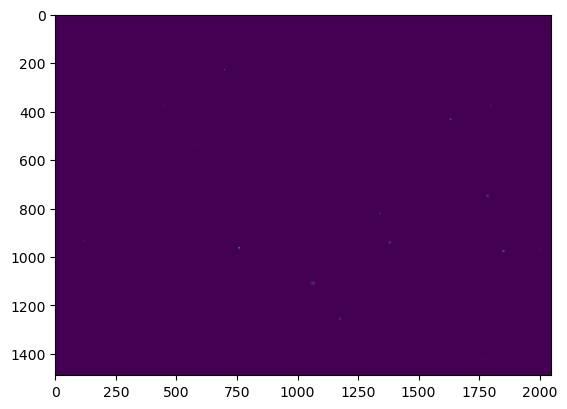

In [6]:

from astropy.io import fits
import matplotlib.pyplot as plt
hdu_list = fits.open('Picture\\46311213.fits')
image_data = hdu_list[0].data
plt.imshow(image_data)
plt.show()
hdu_list.close()

In [15]:
import pandas as pd

# 读取两个CSV文件
aa_df = pd.read_csv('归一化后的文件.csv')
bb_df = pd.read_csv('DR11中所有的在权威星表里的无重复红巨星.csv')

# 筛选出bb.csv中，obsid在aa.csv中的行
filtered_bb_df = bb_df[bb_df['obsid'].isin(aa_df['obsid'])]

# 提取RA和DE两列
result_df = filtered_bb_df[['obsid','ra', 'dec']]

# 查看结果
print(result_df)

# 如果需要保存结果到新的CSV文件
result_df.to_csv('filtered_bb.csv', index=False)

           obsid          ra        dec
1       19506124  126.358819  10.752915
2       26806207  200.776442  -2.289664
3       41603066  132.786658  15.796646
4       41603159  133.004878  15.942460
5       41614020  131.945671  16.609234
...          ...         ...        ...
2196  1057405239   21.309648   2.885967
2199   964002247   18.652203   1.211439
2202   938707249   20.668509   0.188983
2203   938704236   19.904318   1.782398
2204   938701078   19.162235  -0.010617

[1362 rows x 3 columns]


In [42]:
from PIL import Image
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import astropy.units as u
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import time
#这个函数用来把过小的灰度图填充到100*100
def pad_image_to_size(image,x_padding,y_padding,target_size=(100, 100)):
    img = image
    # 计算填充的尺寸
#     print(x_padding)
#     print(y_padding)
#     print(img.shape)
    
    # 填充图片
    padded_img = np.zeros((100,100))# 'L'模式为灰度图
    padded_img[y_padding:y_padding+img.shape[0],x_padding:x_padding+img.shape[1]]=img
    
    return padded_img
# 这个函数可以把一个输入的fits图像（注意只有图像，不是包含其他部分的fits）裁剪成以给定的赤经赤纬为中心的更小的正方形图片
# def cut_fits(orginal_pic,ra,dec,size=100):
    
    
#     hdu = orginal_pic
#     wcs = WCS(hdu.header)
#     data = hdu.data

#     # 将给定的赤经和赤纬转换为图像坐标
#     x_center, y_center = wcs.world_to_pixel_values(ra, dec)

#     # 计算裁剪的边界
#     x_min = int(x_center - size / 2)
#     x_max = int(x_center + size / 2)
#     y_min = int(y_center - size / 2)
#     y_max = int(y_center + size / 2)

#     # 裁剪图像
#     cropped_data = data[y_min:y_max, x_min:x_max]
#     # 更新WCS信息
#     cropped_wcs = wcs.slice((slice(y_min, y_max), slice(x_min, x_max)))
#     hdu_cropped = fits.PrimaryHDU(data=cropped_data, header=cropped_wcs.to_header())
#     return hdu_cropped
# 这个函数可以把一个输入的有五个波段的fits文件裁剪并合并成一个fits文件
def cut_and_merge_fits(orginal_fits,ra,dec,size=100):
    pics=[]
    for i in range(5):
        hdu = orginal_fits[i][0]
        wcs = WCS(hdu.header)
        data = hdu.data

    # 将给定的赤经和赤纬转换为图像坐标
        x_center, y_center = wcs.world_to_pixel_values(ra, dec)

    # 计算裁剪的边界
        x_min = max(int(x_center - size / 2),0)
        left_padding=x_min-int(x_center - size / 2)
        x_max = min(int(x_center + size / 2),data.shape[1])
        y_min = max(int(y_center - size / 2),0)
        up_padding=y_min-int(y_center - size / 2)
        y_max = min(int(y_center + size / 2),data.shape[0])
#         print(f"x_center{x_center}")
#         print(f"y_center{y_center}")
#         print(data.shape)
#         print(f"x_min{x_min}")
#         print(f"y_min{y_min}")
#         print(f"y_max{y_max}")
    # 裁剪图像
        cropped_data = data[y_min:y_max, x_min:x_max]
        #print(cropped_data)
        if cropped_data.shape[0]==0 or cropped_data.shape[1]==0:
            return None
        if cropped_data.shape!= (100,100):
            cropped_data=pad_image_to_size(cropped_data,left_padding,up_padding, target_size=(100, 100))
        pics.append(cropped_data)

    # 将所有数据堆叠成一个numpy数组，新的维度包含不同的波段
    combined_data = np.stack(pics, axis=0)

    # 创建一个新的HDU（Header Data Unit）
    hdu = fits.PrimaryHDU(combined_data)

    return hdu

In [43]:
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import astropy.units as u
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import time
 


# 读取两个CSV文件
df = pd.read_csv('missing_obsid.csv')
# 示例赤经和赤纬（单位为度）
fails=[]

# 遍历每个坐标，下载图像
for i in range(len(df)):
    time.sleep(1)
    # 创建坐标对象
    obsid=df['obsid'][i]
    ra=df['ra'][i]
    dec=df['dec'][i]
    pos = coords.SkyCoord(ra, dec, unit=(u.deg, u.deg), frame='icrs')

    # 从SDSS下载图像
    xid = SDSS.query_region(pos, radius=1.0/3600 * u.deg, photoobj_fields=['ra', 'dec', 'objid','run','rerun','camcol','field'])
    print(f'obsid: {obsid}')
    if xid is not None:
        #pos2=coords.SkyCoord(xid[0][1], xid[0][2], unit=(u.deg, u.deg), frame='icrs')
        # 下载图像
        images = SDSS.get_images(matches=xid[0:1],radius=1.0/3600 * u.deg, band='ugriz')  # 'g'为波段, 可以是'u', 'g', 'r', 'i', 'z'
        pic=cut_and_merge_fits(images,ra,dec,size=100)
        if pic is None:
            print(f'No data found for obsid: {obsid}')
            fails.append(obsid)
            continue
        pic.writeto(f"C:\\Users\\DELL'\\Downloads\\redGiantImages\\{obsid}.fits", overwrite=True)
        # 裁剪到一个不太大的大小，目前是100*100
#         size = 100
#         pic=cut_fits(images[0][0],ra,dec,size=100)
#         pic.writeto(f"C:\\Users\\DELL'\\Downloads\\redGiantImages\\{obsid}_u.fits", overwrite=True)
#         pic=cut_fits(images[1][0],ra,dec,size=100)
#         pic.writeto(f"C:\\Users\\DELL'\\Downloads\\redGiantImages\\{obsid}_g.fits", overwrite=True)
#         pic=cut_fits(images[2][0],ra,dec,size=100)
#         pic.writeto(f"C:\\Users\\DELL'\\Downloads\\redGiantImages\\{obsid}_r.fits", overwrite=True)
#         pic=cut_fits(images[3][0],ra,dec,size=100)
#         pic.writeto(f"C:\\Users\\DELL'\\Downloads\\redGiantImages\\{obsid}_i.fits", overwrite=True)
#         pic=cut_fits(images[4][0],ra,dec,size=100)
#         pic.writeto(f"C:\\Users\\DELL'\\Downloads\\redGiantImages\\{obsid}_z.fits", overwrite=True)
        

    else:
        print(f'No data found for obsid: {obsid}')
        fails.append(obsid)
        


obsid: 26806207
No data found for obsid: 26806207
obsid: 94307097
No data found for obsid: 94307097
obsid: 94307221


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 94312098
No data found for obsid: 94312098
obsid: 99914182
No data found for obsid: 99914182
obsid: 116807127


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 116815015


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 119705115
No data found for obsid: 119705115
obsid: 125503017


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 132502139


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 135805089


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 135805186


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 160113215
No data found for obsid: 160113215
obsid: 187401033


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 187406203


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 187407029


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 187509202


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 195404192
No data found for obsid: 195404192
obsid: 195409122
No data found for obsid: 195409122
obsid: 195411023


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 195414135
No data found for obsid: 195414135
obsid: 203013042


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 205211107


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '21/03/99' to '1999-03-21''. [astropy.wcs.wcs]


obsid: 206814031


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '21/03/99' to '1999-03-21''. [astropy.wcs.wcs]


obsid: 208513231


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '21/03/99' to '1999-03-21''. [astropy.wcs.wcs]


obsid: 227306177


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 227308007


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 227312222


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 227408222


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 227409060


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 229710206


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 248703247


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 248704129
No data found for obsid: 248704129
obsid: 248710106
No data found for obsid: 248710106
obsid: 248715073


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 248715224
No data found for obsid: 248715224
obsid: 250214208


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 254202033


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 254216065
No data found for obsid: 254216065
obsid: 256907054


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '19/09/98' to '1998-09-19''. [astropy.wcs.wcs]


obsid: 264513039


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 277316231
No data found for obsid: 277316231
obsid: 286906192
No data found for obsid: 286906192
obsid: 314511056


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 314511098


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 314512029


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 314515115


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 337504048


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 337505230


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 339809171
No data found for obsid: 339809171
obsid: 339812081


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 340503098


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 379311126


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 387507056


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 387706107


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 387706220


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 391804240


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 391806139


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 391815193


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 399210087


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 406401213


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 406406068


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 414605209


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 414615034


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 420211008
No data found for obsid: 420211008
obsid: 420908072


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 420915008


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 420915100


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 421204140
No data found for obsid: 421204140
obsid: 421204149
No data found for obsid: 421204149
obsid: 421205106
No data found for obsid: 421205106
obsid: 423003150


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 423004161
No data found for obsid: 423004161
obsid: 423005217


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 423014158
No data found for obsid: 423014158
obsid: 423014185
No data found for obsid: 423014185
obsid: 427902231


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 427910238


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 427915058
No data found for obsid: 427915058
obsid: 432608030


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 432714160


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 439616120


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 442904048


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 442912232


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 476213235


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 498714131
No data found for obsid: 498714131
obsid: 628515137


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 661511180


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 700113004


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 713406197


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 807412188


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '21/03/99' to '1999-03-21''. [astropy.wcs.wcs]


obsid: 874713225


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


obsid: 883111159
No data found for obsid: 883111159
obsid: 1059303188


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [44]:

fails

[26806207,
 94307097,
 94312098,
 99914182,
 119705115,
 160113215,
 195404192,
 195409122,
 195414135,
 248704129,
 248710106,
 248715224,
 254216065,
 277316231,
 286906192,
 339809171,
 420211008,
 421204140,
 421204149,
 421205106,
 423004161,
 423014158,
 423014185,
 427915058,
 498714131,
 883111159]

In [14]:
type(images[0][0].data)

numpy.ndarray

In [106]:
images = SDSS.get_images(matches=xid[0:1],radius=1.0/360000 * u.deg, band='ugriz')  

In [121]:
from astropy.io import fits
import numpy as np

a=cut_and_merge_fits(images,126.358819, 10.752915,size=100)
a.writeto('combined.fits', overwrite=True)

In [118]:
def cut_and_merge_fits(orginal_fits,ra,dec,size=100):
    for i in range(5):
        hdu = orginal_fits[i][0]
        wcs = WCS(hdu.header)
        data = hdu.data

    # 将给定的赤经和赤纬转换为图像坐标
        x_center, y_center = wcs.world_to_pixel_values(ra, dec)

    # 计算裁剪的边界
        x_min = int(x_center - size / 2)
        x_max = int(x_center + size / 2)
        y_min = int(y_center - size / 2)
        y_max = int(y_center + size / 2)

    # 裁剪图像
        cropped_data = data[y_min:y_max, x_min:x_max]
        cropped_wcs = wcs.slice((slice(y_min, y_max), slice(x_min, x_max)))
        #hdu_cropped = fits.PrimaryHDU(data=cropped_data, header=cropped_wcs.to_header())
        orginal_fits[i][0].data=cropped_data
        orginal_fits[i][0].header=cropped_wcs.to_header()




    return orginal_fits
a=cut_and_merge_fits(images,126.358819, 10.752915,size=100)
a.writeto('combined.fits', overwrite=True)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


AttributeError: 'list' object has no attribute 'writeto'

In [79]:
a=images[0][0]
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
    # 打开FITS文件

hdu = a
wcs = WCS(hdu.header)
data = hdu.data
size = 100
    # 将给定的赤经和赤纬转换为图像坐标
x_center, y_center = wcs.world_to_pixel_values(126.358819, 10.752915)

    # 计算裁剪的边界
x_min = int(x_center - size / 2)
x_max = int(x_center + size / 2)
y_min = int(y_center - size / 2)
y_max = int(y_center + size / 2)

    # 裁剪图像
cropped_data = data[y_min:y_max, x_min:x_max]
cropped_wcs = wcs.slice((slice(y_min, y_max), slice(x_min, x_max)))
    # 创建新的FITS HDU

    # 更新WCS信息（可选）
hdu_cropped = fits.PrimaryHDU(data=cropped_data, header=cropped_wcs.to_header())

    # 保存为新的FITS文件
hdu_cropped.writeto(f"C:\\Users\\DELL'\\Downloads\\redGiantImages\\cut2.fits", overwrite=True)

In [108]:
# 这段代码试图把五个波段的数据存在fits文件里，分开的，还没实现
def cut_and_fits(orginal_fits,ra,dec,size=100):
    pics=[]
    flag=True

    for i in range(5):
        hdu = orginal_fits[i][0]
        wcs = WCS(hdu.header)
        data = hdu.data

    # 将给定的赤经和赤纬转换为图像坐标
        x_center, y_center = wcs.world_to_pixel_values(ra, dec)

    # 计算裁剪的边界
        x_min = int(x_center - size / 2)
        x_max = int(x_center + size / 2)
        y_min = int(y_center - size / 2)
        y_max = int(y_center + size / 2)

    # 裁剪图像
        cropped_data = data[y_min:y_max, x_min:x_max]
        pics.append(cropped_data)

        cropped_wcs = wcs.slice((slice(y_min, y_max), slice(x_min, x_max)))
        hdu_cropped = fits.PrimaryHDU(data=cropped_data, header=cropped_wcs.to_header())
        pics.append(hdu_cropped)
    # 更新WCS信息
    hdul = fits.HDUList(pics)
    hdul.writeto('merged_image.fits', overwrite=True)
    return hdul

In [95]:
# 假设您有五个FITS文件的路径
images = [images[0][0], images[1][0], images[2][0], images[3][0], images[4][0]]

hdu_list = []
for i, image in enumerate(images):
    hdu = fits.PrimaryHDU(image)
    hdu.header['BAND'] = i + 1  # 添加波段信息
    hdu_list.append(hdu)

# 创建一个新的 FITS 文件
hdul = fits.HDUList(hdu_list)
hdul.writeto('merged_image.fits', overwrite=True)
# 写入到一个新的FITS文件中
#hdu.writeto('combined.fits', overwrite=True)

TypeError: data object array(<astropy.io.fits.hdu.image.PrimaryHDU object at 0x00000243BAFBE5C0>,
      dtype=object) should have at least one dimension

In [19]:
# 这段用来把fits文件裁剪成指定的大小，是用来选取模型输入大小做的
from astropy.io import fits
import numpy as np
import os
source_folder="C:\\Users\\DELL'\\Downloads\\final_cross_validation_data\\test\\input\\"
destination_folder="C:\\Users\\DELL'\\Downloads\\pic96\\"
os.makedirs(destination_folder, exist_ok=True)
orginalSize=100
targetSize=96
cut=(orginalSize-targetSize)//2
for filename in os.listdir(source_folder):
    if filename.endswith('.fits'):
        # 构建完整文件路径
        
        file_path = os.path.join(source_folder, filename)
        hdu=fits.open(file_path)
        data =  hdu[0].data.astype(np.float32)
        processed_data = data[:,cut:orginalSize-cut, cut:orginalSize-cut]
        hdu_cropped = fits.PrimaryHDU(data=processed_data)
            
            # 保存到BB文件夹
        new_file_path = os.path.join(destination_folder, filename)
        hdu_cropped.writeto(new_file_path, overwrite=True)
        hdu.close()




In [2]:
# 这段是为了算红移值写的
import pandas as pd
aa = pd.read_csv('DR11中所有的在权威星表里的有图片的10信噪比无重复红巨星.csv')
bb=pd.read_csv('归一化后的文件.csv')
merged = pd.merge(aa, bb, left_on='obsid', right_on='obsid', how='right')
result = merged[['obsid','Teff', 'log(g)','[M/H]','Mass','Radius','z']]
result.to_csv('红移.csv', index=False)

In [7]:
# 这段代码把光谱红移矫正
import numpy as np
from scipy.interpolate import splrep, splev
import pandas as pd
infolder='LowResSpectrum\\'
output_folder = 'noredshiftcutLowResSpectrum\\'
df = pd.read_csv('红移.csv',dtype=str)
for i in range(len(df["obsid"])):
    spec=pd.read_csv(infolder+df["obsid"][i]+".csv",dtype=float)
    Wavelength=spec["Wavelength"].to_numpy()
    Flux=spec["Flux"].to_numpy()
    noRedshiftWaveLength=Wavelength/(1+float(df["z"][i]))
    tck = splrep(noRedshiftWaveLength, Flux)
 
    # 插值点
    x_new = np.linspace(3710, 8709, 5000)

    # 计算插值点的值
    y_new = splev(x_new, tck)
    y_new=(y_new-np.mean(y_new))/np.std(y_new)
    temp = pd.DataFrame(y_new)
    temp.to_csv(output_folder+df["obsid"][i]+".csv", index=False, header=False) 
    

In [ ]:
import numpy as np
from scipy.interpolate import splrep, splev
import random
def randRedShift(waveLength,Lux,z):
    randZ=random.random()
    waveLength=waveLength*(1+randZ)/(1+z)
    tck = splrep(waveLength, Flux)
    x_new = np.linspace(3710, 8709, 5000)
    y_new = splev(x_new, tck)
    y_new=(y_new-np.mean(y_new))/np.std(y_new)
    return y_new

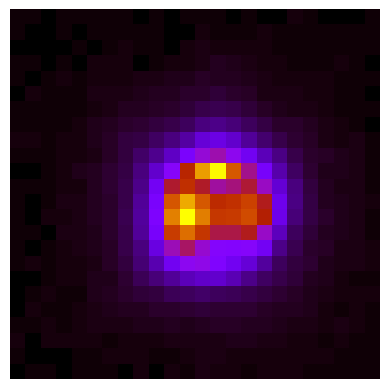

In [27]:
# 这段代码是写论文画图用的
from PIL import Image
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import astropy.units as u
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import time
import matplotlib.pyplot as plt
#这个函数用来把过小的灰度图填充到100*100

# 这个函数可以把一个输入的fits图像（注意只有图像，不是包含其他部分的fits）裁剪成以给定的赤经赤纬为中心的更小的正方形图片
# def cut_fits(orginal_pic,ra,dec,size=100):
    
    
#     hdu = orginal_pic
#     wcs = WCS(hdu.header)
#     data = hdu.data

#     # 将给定的赤经和赤纬转换为图像坐标
#     x_center, y_center = wcs.world_to_pixel_values(ra, dec)

#     # 计算裁剪的边界
#     x_min = int(x_center - size / 2)
#     x_max = int(x_center + size / 2)
#     y_min = int(y_center - size / 2)
#     y_max = int(y_center + size / 2)

#     # 裁剪图像
#     cropped_data = data[y_min:y_max, x_min:x_max]
#     # 更新WCS信息
#     cropped_wcs = wcs.slice((slice(y_min, y_max), slice(x_min, x_max)))
#     hdu_cropped = fits.PrimaryHDU(data=cropped_data, header=cropped_wcs.to_header())
#     return hdu_cropped
# 这个函数可以把一个输入的有五个波段的fits文件裁剪并合并成一个fits文件
hdu=fits.open("C:\\Users\DELL'\\Downloads\\pic24\\19506124.fits")#45204028
data =  hdu[0].data.astype(np.float32)
fig, ax = plt.subplots()
heatmap = ax.imshow(data[3], cmap='gnuplot')
 
# 为热力图增加颜色条标记
# fig.colorbar(heatmap)
plt.axis('off')
# plt.title('z')
fig.patch.set_alpha(0.0) 
fig.savefig('i0.svg', format='svg')
plt.show() 

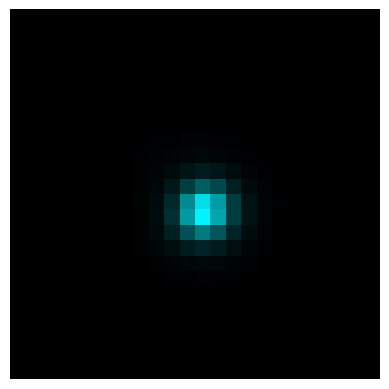

In [97]:

from PIL import Image
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import astropy.units as u
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 自定义从黑色到绿色的 colormap
colors = [(0, 0, 0), (0, 243/255, 1)]  # 黑色到绿色
custom_cmap = LinearSegmentedColormap.from_list("black_to_green", colors)
hdu=fits.open("C:\\Users\DELL'\\Downloads\\pic24\\19506124.fits")#45204028
data =  hdu[0].data.astype(np.float32)
fig, ax = plt.subplots()
heatmap = ax.imshow(data[1], cmap="gray")
 
# 为热力图增加颜色条标记
# fig.colorbar(heatmap)
plt.axis('off')
# plt.title('z')
fig.patch.set_alpha(0.0) 
fig.savefig('3Dg.svg', format='svg')
plt.show() 

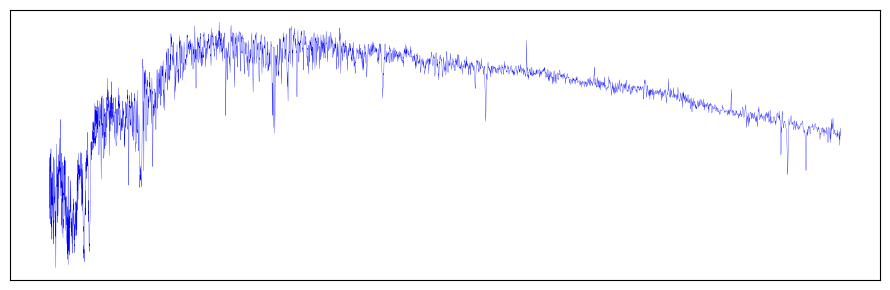

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设你的 CSV 文件为 'data.csv'，读取数据
# CSV 文件应包含两列：第一列为自变量（如 x），第二列为因变量（如 y）
data = pd.read_csv("C:\\Users\DELL'\\Downloads\\Spectrum\\19506124.csv")

# 确保数据按自变量递增排序
data = data.sort_values(by=data.columns[0])

# 绘制折线图
plt.figure(figsize=(9, 3))  # 调整图像尺寸为“高瘦”状，宽度为 4，高度为 8
plt.plot(data.iloc[11:3809, 0], data.iloc[11:3809, 1], color='blue', linewidth=0.2)

# 去掉坐标轴
# plt.axis('off')

# # 边框
plt.gca().set_frame_on(True)
plt.gca().tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# 保留外框
# plt.gca().spines['top'].set_visible(True)
# plt.gca().spines['right'].set_visible(True)
# plt.gca().spines['left'].set_visible(True)
# plt.gca().spines['bottom'].set_visible(True)

# 设置显示比例
plt.tight_layout()

# 保存或显示图片
# plt.savefig('spec.svg', format='svg')
# plt.savefig('line_plot.png', bbox_inches='tight', dpi=300)  # 保存为图片
plt.show()  # 显示图片

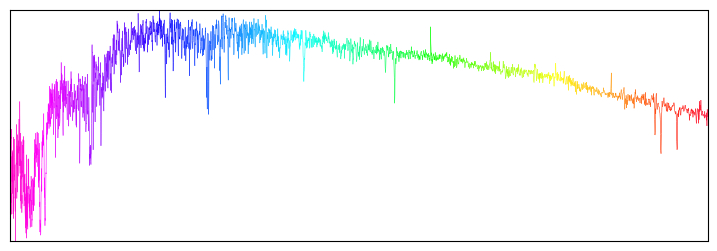

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

# 生成示例数据

data = pd.read_csv("C:\\Users\DELL'\\Downloads\\Spectrum\\19506124.csv")

# 确保数据按自变量递增排序
data = data.sort_values(by=data.columns[0])
x=data.iloc[11:3809, 0]
y=data.iloc[11:3809, 1]
# 绘制折线图
  # 调整图像尺寸为“高瘦”状，宽度为 4，高度为 8

# 创建渐变颜色
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# 创建颜色映射（可以自定义 colormap）
cmap = plt.get_cmap('gist_rainbow_r')  # 使用 'viridis' 渐变颜色方案
norm = plt.Normalize(x.min(), x.max())  # 根据 X 坐标的范围归一化颜色

# 创建渐变的折线
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(x)  # 将 X 坐标映射到颜色
lc.set_linewidth(0.4)  # 设置线条宽度

# 创建图表
fig, ax = plt.subplots(figsize=(9, 3))
ax.add_collection(lc)  # 添加渐变线条到图表
# ax.autoscale()  # 自动调整坐标轴范围
ax.set_xlim(x.min(), x.max())  # 设置 X 轴范围
ax.set_ylim(y.min(), y.max())  # 设置 Y 轴范围

# plt.axis('off')
plt.gca().set_frame_on(True)
plt.gca().tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
# 添加颜色条
# cbar = plt.colorbar(lc, ax=ax)
# cbar.set_label('X Coordinate')

# 显示图表
plt.savefig('rainbowspec.svg', format='svg')
plt.show()


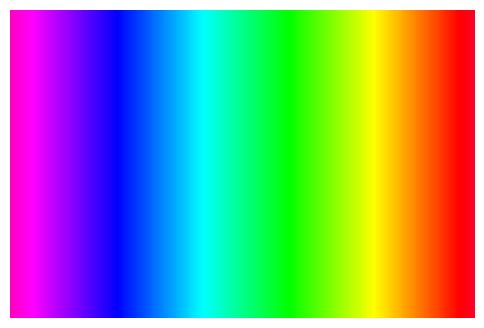

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# 创建数据


# 创建渐变颜色
# cmap = plt.get_cmap('gist_rainbow_r')  # 使用 matplotlib 内置的 colormap，例如 'viridis'
gradient = np.linspace(0, 1, 500).reshape(1, -1)  # 1 行，500 列
gradient = np.vstack([gradient] * 500)  # 将这一行复制 500 次，形成一个矩形

# 创建图形
fig, ax = plt.subplots(figsize=(6, 4))  # 可以调整 figsize 改变图大小

# 使用 imshow 绘制渐变矩形
# cmap 指定颜色映射，比如 'viridis', 'plasma', 'inferno', 或者其他 colormap
ax.imshow(gradient, aspect='auto', cmap='gist_rainbow_r', interpolation='nearest')
plt.axis('off')
plt.savefig('rainbow.svg', format='svg')
# 显示图形
plt.show()

In [78]:
# 这个代码是用来展示图片打乱的
from PIL import Image
import random

def split_and_shuffle_image(image_path, output_path, rows=6, cols=6):
    # 打开图片
    img = Image.open(image_path)
    img_width, img_height = img.size

    # 计算每块的宽度和高度
    block_width = img_width // cols
    block_height = img_height // rows

    # 分割图片为若干块
    blocks = []
    for row in range(rows):
        for col in range(cols):
            left = col * block_width
            upper = row * block_height
            right = left + block_width
            lower = upper + block_height
            block = img.crop((left, upper, right, lower))
            blocks.append(block)

    # 打乱这些块的顺序
    random.shuffle(blocks)

    # 创建一个新的图片用于拼接
    shuffled_img = Image.new("RGB", (img_width, img_height))

    # 将打乱的块重新排列
    for row in range(rows):
        for col in range(cols):
            block = blocks.pop(0)
            left = col * block_width
            upper = row * block_height
            shuffled_img.paste(block, (left, upper))

    # 保存新图片
    shuffled_img.save(output_path)
    print(f"图片已保存到 {output_path}")

# 使用示例
# 输入图片路径和输出图片路径
input_image_path = "cat.jpg"  # 替换为你的图片路径
output_image_path = "output.jpg"  # 替换为输出图片路径

# 调用函数
split_and_shuffle_image(input_image_path, output_image_path)

图片已保存到 output.jpg


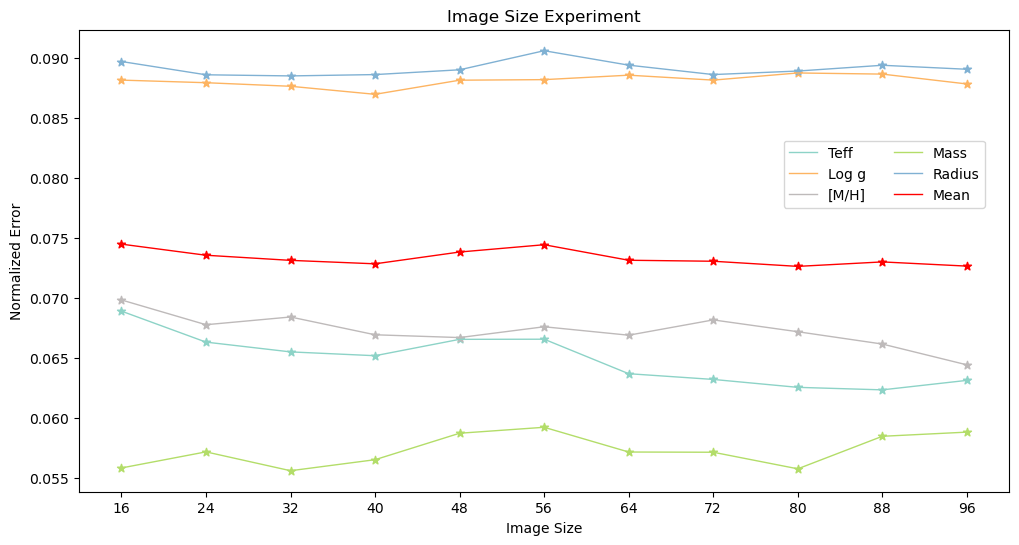

In [1]:
import numpy as np
import matplotlib.pyplot as plt
data = np.loadtxt('制表用临时文件.csv', delimiter=',')

x = data[:,0]
y = data[:,1]
# plt.axis([8, 100, 0.05, 0.09])
# ax=plt.gca()
fig = plt.figure(figsize=(12, 6))
plt.scatter(x, y, color='#8DD3C7',marker="*")
plt.plot(x, y, color='#8DD3C7', label='Teff', linewidth=1)
y = data[:,2]
plt.scatter(x, y,color='#FDB462',marker="*")
plt.plot(x, y, color='#FDB462', label='Log g', linewidth=1)
y = data[:,3]
plt.scatter(x, y,color='#BEBABA',marker="*")
plt.plot(x, y, color='#BEBABA', label='[M/H]', linewidth=1)
y = data[:,4]
plt.scatter(x, y,color='#B3DD69',marker="*")
plt.plot(x, y, color='#B3DD69', label='Mass', linewidth=1)
y = data[:,5]
plt.scatter(x, y,color='#80B1D3',marker="*")
plt.plot(x, y, color='#80B1D3', label='Radius', linewidth=1)
y = data[:,6]
plt.scatter(x, y,color='red',marker="*")
plt.plot(x, y, color='red', label='Mean', linewidth=1)
plt.xticks(x)
plt.title('Image Size Experiment')
plt.xlabel('Image Size')
plt.ylabel('Normalized Error')
plt.legend(bbox_to_anchor=(0.75, 0.6),ncol=2)
plt.savefig('Image Size Experiment.svg',bbox_inches='tight')

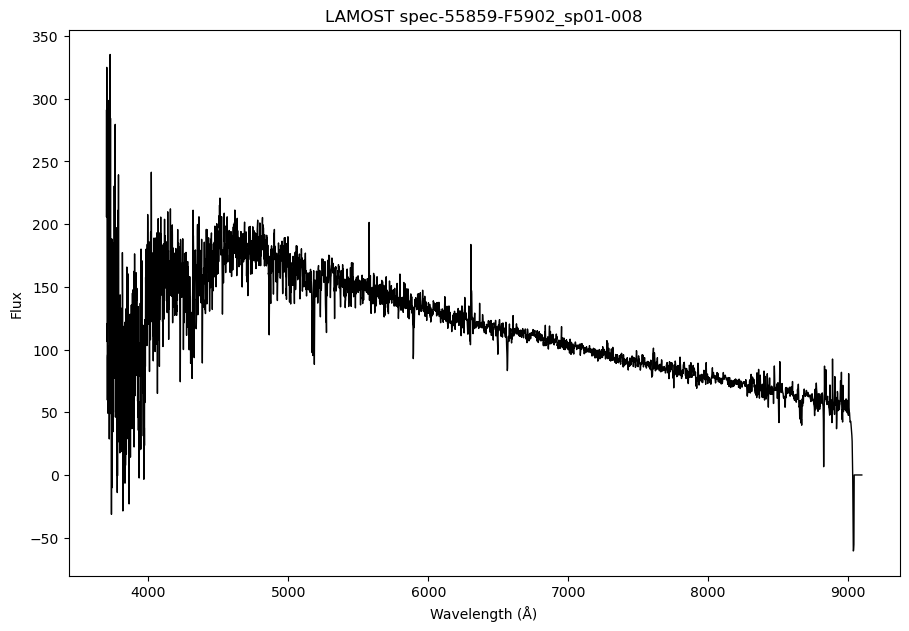

In [115]:
import numpy as np
import matplotlib.pyplot as plt
data = np.loadtxt('示例光谱.csv', delimiter=',', skiprows=1)
# x = data[2004:3070,0]
# y = data[2004:3070,1]
# x = data[120:1400,0]
# y = data[120:1400,1]
x = data[:,0]
y = data[:,1]
plt.figure(figsize=(9, 6)) 
plt.plot(x, y, color='black', linewidth=1)
# plt.gca().set_frame_on(True)
# plt.gca().tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
# plt.axis('off')
plt.tight_layout()
# plt.title('Image Size Experiment')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.title("LAMOST spec-55859-F5902_sp01-008")
# plt.axis([5000, 8800,25,200])
plt.savefig('realF.svg',bbox_inches='tight')

In [116]:
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import astropy.units as u
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import time
 


# 读取两个CSV文件

    # 创建坐标对象

pos = coords.SkyCoord(126.358819, 10.752915, unit=(u.deg, u.deg), frame='icrs')

# 从SDSS下载图像
xid = SDSS.query_region(pos, radius=1.0/3600 * u.deg, photoobj_fields=['ra', 'dec', 'objid','run','rerun','camcol','field'])

images = SDSS.get_images(matches=xid[0:1],radius=1.0/3600 * u.deg, band='u')  # 'g'为波段, 可以是'u', 'g', 'r', 'i', 'z'
#     pic=cut_and_merge_fits(images,ra,dec,size=100)

    # 裁剪到一个不太大的大小，目前是100*100
#         size = 100
#         pic=cut_fits(images[0][0],ra,dec,size=100)
#         pic.writeto(f"C:\\Users\\DELL'\\Downloads\\redGiantImages\\{obsid}_u.fits", overwrite=True)
#         pic=cut_fits(images[1][0],ra,dec,size=100)
#         pic.writeto(f"C:\\Users\\DELL'\\Downloads\\redGiantImages\\{obsid}_g.fits", overwrite=True)
#         pic=cut_fits(images[2][0],ra,dec,size=100)
#         pic.writeto(f"C:\\Users\\DELL'\\Downloads\\redGiantImages\\{obsid}_r.fits", overwrite=True)
#         pic=cut_fits(images[3][0],ra,dec,size=100)
#         pic.writeto(f"C:\\Users\\DELL'\\Downloads\\redGiantImages\\{obsid}_i.fits", overwrite=True)
#         pic=cut_fits(images[4][0],ra,dec,size=100)
#         pic.writeto(f"C:\\Users\\DELL'\\Downloads\\redGiantImages\\{obsid}_z.fits", overwrite=True)



        

In [117]:
hdu = images[0][0]
wcs = WCS(hdu.header)
data = hdu.data

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


C:\Users\DELL'\.conda\envs\test\lib\site-packages\matplotlib\image.py:505: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)


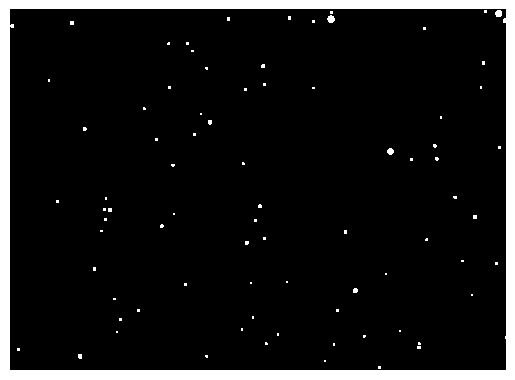

In [137]:
# data =  hdu[0].data.astype(np.float32)
fig, ax = plt.subplots()
heatmap = ax.imshow(a, cmap="gnuplot")
 
# 为热力图增加颜色条标记
# fig.colorbar(heatmap)
plt.axis('off')
# plt.title('z')
# fig.patch.set_alpha(0.0) 
fig.savefig('ppp.svg', format='svg')
plt.show() 

In [136]:
a=np.exp(data*200)

C:\Users\DELL'\AppData\Local\Temp\ipykernel_2848\3814121668.py:1: RuntimeWarning: overflow encountered in exp
  a=np.exp(data*200)
